# Literature

```
POSNER, MICHAEL I.; GOLDSMITH, RALPH; WELTON, KENNETH E., Jr. (1967). PERCEIVED DISTANCE AND THE CLASSIFICATION OF DISTORTED PATTERNS.. Journal of Experimental Psychology, 73(1), 28–38. doi:10.1037/h0024135  
```

https://sci.bban.top/pdf/10.1037/h0024135.pdf#view=FitH

```
Smith, J. David; Redford, Joshua S.; Gent, Lauren C.; Washburn, David A. (2005). Visual Search and the Collapse of Categorization.. Journal of Experimental Psychology: General, 134(4), 443–460. doi:10.1037/0096-3445.134.4.443  
```
https://sci-hub.yncjkj.com/10.1037/0096-3445.134.4.443

![Posner, 1967](assets/posner-1967-fig1.png)

![Smith, 2005. Figure 1](assets/smith-2005-fig1.png)

![Smith, 2005](assets/smith-2005-appendix.png)

# Tools

mpl_point_clicker. Extension to matplotlib that lets you click on points on a graph. https://mpl-point-clicker.readthedocs.io/en/latest/

In [2079]:
import imageio
import numpy as np
import random

In [2080]:
def random_points_from_grid(num_points=9, central_area_side=30, total_area_side=50):
    '''
    "Choose 9 points randomly from the central 30x30 area of a 50x50 grid"
    Becomes the initial point of the dot distortion shapes.
    '''
    points = []
    for i in range(num_points):
        x = random.randint(total_area_side/2-central_area_side/2, total_area_side/2 + central_area_side/2)
        y = random.randint(total_area_side/2-central_area_side/2, total_area_side/2 + central_area_side/2)
        points.append((x, y))
    return points

In [2081]:
def create_relative_coordinates(dot_block_image_path='dot_distortion_areas.png'):
    '''
    I created a 21x21 pixel PNG image using GIMP that has different brightness values for each kind of 'area'.
    This function parses that image to return a list of tuples of relative coordinates for each area.
    Areas are 1,2,3,4,5.
    '''
    im = imageio.imread(dot_block_image_path)

    pixel_brightness = sorted(set(im[10]))
    brightness_to_areas = dict()
    for i, num in enumerate(pixel_brightness):
        brightness_to_areas.update({num: i+1})

    areas_array = np.zeros(im.shape)

    for i in range(len(areas_array)):
        for j in range(len(areas_array[i])):
            areas_array[i][j] = brightness_to_areas[im[i][j]]

    assert set(areas_array.flatten()) == {1, 2, 3, 4, 5} # ensure that all pixel values have been converted to areas indexes

    coords_per_area = []
    for k in range(1,len(set(areas_array.flatten()))+1):
        coords_per_area.append([(i,j) for i in range(len(areas_array)) for j in range(len(areas_array[i])) if areas_array[i][j] == k])

    # subtract (10,10) from all coords; turn into relative values from center pixel
    rel_coords_per_area = coords_per_area
    for i in range(len(coords_per_area)):
        rel_coords_per_area[i] = [(x-10,y-10) for (x,y) in coords_per_area[i]]

    return rel_coords_per_area
        

In [2082]:
def distort_dot(coords, distortion_level, relative_shifts, area_names=[1,2,3,4,5]):
    '''
    Randomly move dot to corresponding area_name according to a probability distribution for area_names given by distortion_level

    coords (tuple(int,int)): (x, y) point coordinates
    distortion_level (str): choose from '1', '2', '3', '4', '5', '6', '7.7'
    relative_shifts (list[list[tuple(int,int)]]): list of lists of relative coordinates for each area_name
    area_names (list[int])
    '''
    level_to_probs = {
        # level names correspond to bits per dot
        # value is the probability distribution over the 5 area_names
        '1' : (0.88, 0.10, 0.015, 0.004, 0.001),
        '2' : (0.75, 0.15, 0.05, 0.03, 0.02),
        '3' : (0.59, 0.20, 0.16, 0.03, 0.02),
        '4' : (0.36, 0.48, 0.06, 0.05, 0.05),
        '5' : (0.20, 0.30, 0.40, 0.05, 0.05),
        '6' : (0, 0.40, 0.32, 0.15, 0.13),
        '7.7': (0, 0.24, 0.16, 0.30, 0.30)
    }
    # check that all probability distributions sum to 1
    for x in ['1','2','3','4','5','6','7.7']:
        assert sum(level_to_probs[x]) == 1.0


    probs = level_to_probs[distortion_level]
    area_selection = np.random.choice(area_names, p=probs)
    pixel_shift_selection = random.choice(relative_shifts[area_selection-1])
    return (coords[0] + pixel_shift_selection[0], coords[1] + pixel_shift_selection[1])
    

In [2083]:
def scale_coords(coords, scale_factor=3):
    '''
    Scale coordinates by a factor
    '''
    return (coords[0]*scale_factor, coords[1]*scale_factor)

In [2084]:
relative_shifts = create_relative_coordinates()

In [2085]:
distort_dot(coords=(10,10), distortion_level='6', relative_shifts=relative_shifts)

(11, 9)

In [2086]:
shifted_points = []
for p in random_points_from_grid():
    shifted_points.append(distort_dot(coords=p, distortion_level='6', relative_shifts=relative_shifts))

In [2087]:
shifted_points

[(43, 25),
 (38, 24),
 (13, 25),
 (8, 17),
 (28, 14),
 (16, 29),
 (22, 31),
 (13, 36),
 (16, 20)]

In [2088]:
scaled_points = [scale_coords(c, scale_factor=3) for c in shifted_points]

In [2089]:
scaled_points

[(129, 75),
 (114, 72),
 (39, 75),
 (24, 51),
 (84, 42),
 (48, 87),
 (66, 93),
 (39, 108),
 (48, 60)]

In [2090]:
scaled_points

[(129, 75),
 (114, 72),
 (39, 75),
 (24, 51),
 (84, 42),
 (48, 87),
 (66, 93),
 (39, 108),
 (48, 60)]

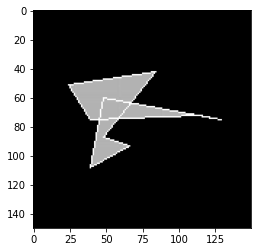

In [2091]:
import cv2
import matplotlib.pyplot as plt
img = np.zeros([150, 150, 1],np.uint8)
a = np.array(scaled_points)
cv2.drawContours(img, [a], 0, (255,255,255), 1) # draw lines

# fill enclosed spaces with white
cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    cv2.drawContours(img,[c], 0, (255,255,255), -1)

# fill white with one of 11 patterns (random)
pattern_num = random.choice(range(1,11+1))
pattern_img = cv2.imread('fill_patterns/p'+str(pattern_num)+'.png', 0)

# stack pattern n times vertically and horizontally (pattern was screenshot from the paper, so not high quality)
pattern_img = np.hstack([pattern_img]*5)
pattern_img = np.vstack([pattern_img]*5)

# resize pattern_img to be the same size as img
pattern_img = cv2.resize(pattern_img, (img.shape[1], img.shape[0]))
img = cv2.bitwise_and(img, pattern_img)

cv2.drawContours(img, [a], 0, (255,255,255), 1) # draw lines
    
plt.imshow(img, cmap='gray')

I created a grayscale image that shows the 5 areas in the 21x21 grid of pixels.


![](dot_distortion_areas.png)

In [2092]:
import imageio
im = imageio.imread('dot_distortion_areas.png')
im[10] # middle line; contains pixel values for all 5 area types

Array([136, 136, 136, 136, 136, 102, 102, 102,  68,  34,   0,  34,  68,
       102, 102, 102, 136, 136, 136, 136, 136], dtype=uint8)

In [2093]:
pixel_brightness = sorted(set(im[10]))
brightness_to_areas = dict()
for i, num in enumerate(pixel_brightness):
    brightness_to_areas.update({num: i+1})

In [2094]:
brightness_to_areas[136]

5

In [2095]:
import numpy as np
areas_array = np.zeros(im.shape)

In [2096]:
for i in range(len(areas_array)):
    for j in range(len(areas_array[i])):
        areas_array[i][j] = brightness_to_areas[im[i][j]]

In [2097]:
areas_array[10]

array([5., 5., 5., 5., 5., 4., 4., 4., 3., 2., 1., 2., 3., 4., 4., 4., 5.,
       5., 5., 5., 5.])

In [2098]:
assert set(areas_array.flatten()) == {1, 2, 3, 4, 5} # ensure that all pixel values have been converted to areas indexes